My recent work on fitting spatial hierarchical multilevel models with Bayesian techniques has divided into three foci, all relevant to the end goals we have discussed of 

1. Fitting hierarchical multilevel models with spatial effects over the health outcomes dataset
2. Providing a flexible method of specifying and fitting these models in a replicable way
3. Review and synthesize current cutting-edge Bayesian methods that may make it possible to fit models more efficiently

I'll summarize the work I've done on this front by showing a bit of the code I've written and how it links up with the models we've been discussing fitting. In addition, I will summarize the developments I've harnessing for the NARSC proposal we've submitted on Hamiltonian/Hybrid Monte Carlo algorithms for spatial model fitting. Hopefully, I'll demonstrate where my work fits into the scope of the literature I mentioned in the other discussion. 

# Fitting multilevel variance components models with spatial effects

Initially on this project, I foucused on writing custom Gibbs sampling implementations. This summer, I've been both preparing to add more models and tried to figure out whether I could beat the performance of the Gibbs sampling stuff using the tools recommended in the broader bayesian literature. 

First, I derived the Gibbs sampler common to any variance components model with spatial effects on either level. This is detailed in a $\LaTeX$ document in the repo and that I've sent, but, in short, for a variance components model of the form:

$$ Y = X\beta + \Delta\alpha + \epsilon $$

Where $\Delta\alpha$ is the upper-level error component and $\epsilon$ the lower-level variance component, we can state the likelihood as:

$$ \mathcal{L}(Y|\beta, \alpha, \sigma^2_e, \rho) \sim \mathcal{N}(X\beta + \Delta\alpha, \Psi(\rho)\sigma^2_e) $$

Where $\Psi(\rho)$ is the spatial covariance component and $\sigma^2_y$ is the scale variance component. We can condition on the random effect, since it has its own "secondary" likelihood that can be sampled from to construct $Y$:

$$ P(\alpha | \tau^2, \lambda) \sim \mathcal{N}(0, \Psi(\lambda)\sigma^2_\alpha) $$

Again, noting that, in the SAR-error and SMA forms, the variance components at each level are separable from the correlative components. For conciseness, when both the spatial and nonspatial variance components in each level are known, let us call the variance-covariance matrices $\Sigma_\alpha$ and $\Sigma_y$.

With this and the following conjugate priors:

$$ \sigma^2_e \sim IG(a_e, b_e) $$
 
$$ \sigma^2_u \sim IG(a_\alpha, b_\alpha) $$

$$ \beta \sim \mathcal{N}(\mu_\beta, \Sigma_{\beta0}) $$

We can derive the following full conditional posteriors. For convenience, let $P(\beta| .)$ denote the full conditional of $\beta$. 

### Beta 

This is derived in Section 1.2 of *A Gibbs Sampler for Multilevel Variance Components Models with Separable Spatial Effects*

$$P(\beta | .)\propto \mathcal{N}(\Sigma_\beta b, \Sigma_\beta)$$

where

$$ \Sigma_\beta = \left(X'\Sigma^{-1}_y + \Sigma_{\beta_0}^{-1} \right)^{-1} $$

$$ b = \left( X'\Sigma^{-1}_y(Y - \Delta\alpha) + \Sigma^{-1}_{\beta0}\mu_\beta \right) $$

### Alpha

$$ P(\alpha | . ) \propto \mathcal{N}(\Sigma_{\alpha'} a, \Sigma_{\alpha'}) $$

$$ \Sigma_{\alpha'} = \left(\Delta'\Sigma^{-1}_y\Delta + \frac{\Phi(\lambda)^{-1}}{\sigma^2_\alpha} \right)^{-1} $$

$$ a = \Delta'\Sigma^{-1}_y(y - X\beta) $$

### Lower-level scale variance component

$$ P(\sigma^2_e | . ) \propto IG \left(\frac{N}{2} + a_{e0}, \frac{\eta'\Psi(\rho)^{-1}\eta}{2} + b_{e0} \right) $$

where $\eta = y - X\beta - \Delta\alpha$. 

### Upper-level scale variance component

$$ P(\sigma^2_\alpha | . ) \propto IG \left(\frac{J}{2} + a_{\alpha0}, \frac{\alpha'\Psi(\lambda)^{-1}\alpha}{2} + b_{\alpha0} \right)$$

### Lower-level spatial correlation parameter

In this case, it is convenient to parameterize the model in terms of a scalar correlation parameter that is applied over a matrix. That's why the matrix-valued spatial correlation function, $\Psi(\rho)$, is kept arbitrary deriving this sampler. To proceed, we consider a scalar-valued prior $P(\rho)$ of an arbitrary form: 

$$ P(\rho | .) \propto |\Psi(\rho)|^{-\frac{1}{2}} \text{exp}\left[-\frac{1}{2\sigma^2_e}\left(\eta'\Psi(\rho)^{-1}\eta\right) \right] \times P(\rho)\biggr\rvert^{\rho_+}_{\rho_-} $$

where the range of the posterior is restricted to the range of the prior. I state this with arbitrary prior $P(\rho)$ because I doubt that, for any choice in $\rho$, the prior will be an analytically tractible function. 

### Upper-level spatial correlation parameter

This has the same form as the lower-level parameter, but applies to the upper-level model for $\alpha$:

$$ P(\lambda | .) \propto |\Psi(\lambda)|^{-\frac{1}{2}} \text{exp}\left[-\frac{1}{2\sigma^2_e} \left(\alpha'\Psi(\lambda)^{-1}\alpha\right) \right] + P(\lambda) \biggr\rvert^{\lambda_+}_{\lambda_-} $$

# Using the sampler

Since we've stated the sampler over arbitrary $\Psi(\rho)$, $\Psi(\lambda)$, any form of dependence can be chosen for $\Psi(\rho)$ as long as it allows us to separate the spatial correlation from the scale parameters $\sigma^2_.$. 


To show how to use the implementation, let's fit a model on southern counties relating to `DNL90` to `GI89`, `BLK90`, and `HR90`, with statewide average `FH90` as an upper-level predictor. 

In [1]:
#seaborn is required for the traceplots
import pysal as ps
import hlm
from hlm.plotting.traces import plot_trace
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df[df.STATE_NAME != 'District of Columbia']
X = df[['GI89', 'BLK90', 'HR90']].values
N = X.shape[0]
Z = df.groupby('STATE_NAME')['FH90'].mean()
Z = Z.values.reshape(-1,1)
J = Z.shape[0]

Y = df.DNL90.values.reshape(-1,1)

In [2]:
W2 = ps.queen_from_shapefile(ps.examples.get_path('us48.shp'), 
                             idVariable='STATE_NAME')
W2 = ps.w_subset(W2, ids=df.STATE_NAME.unique().tolist())
W1 = ps.queen_from_shapefile(ps.examples.get_path('south.shp'),
                             idVariable='FIPS')
W1 = ps.w_subset(W1, ids=df.FIPS.tolist())

W1.transform = 'r'
W2.transform = 'r'
membership = df.STATE_NAME.apply(lambda x: W2.id_order.index(x)).values

The call for almost every sampler is of the following form:

 
`sampler(Y, X, W, M, Z, membership, Delta, n_samples, **configuration)`

Where `Y, X` are the lower-level responses, `W` is the lower-level weights matrix, `M` is the upper-level weights matrix, `Z` is upper-level data, `membership` is a vector containing the relationship between observations in `W` and observations in `M`, `Delta` is the dummy variable matrix corresponding to `membership`, and tons of sample tuning, parameter options, and others are passed through `**configuration`.

Every sampler uses, either in whole or in part, the `generic` update code. In the cases of the single-level samplers, $\Sigma_.$ is replaced with $\sigma_.^2$.


The simplest way to estimate a model of a given form is to make a call that looks exactly like any other call in `pysal` or `statsmodels`:

In [3]:
vcsma = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                      n_samples=5000, tuning=500)

/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


Thus, the model is the `vcsma` object. There are a few things that `vcsma` has and can do.

# `trace`

The quickest way to get information out of the model is via the trace object. This is where the results of the tracked parameters are stored each iteration. Any variable in the sampler state can be added to the tracked params. Trace objects are essentially dictionaries with the keys being the name of the tracked parameter and the values being a list of each iteration's sampler output.

In [4]:
vcsma.trace.varnames

['Alphas', 'Betas', 'Lambda', 'Tau2', 'Sigma2']

I've written two helper functions for working with traces. First is to just dump all the output into a pandas dataframe, which makes it super easy to do work on the samples:

In [5]:
trace_dataframe = vcsma.trace.to_df()

In [6]:
trace_dataframe.mean()

Lambda        0.769734
Sigma2        1.276193
Tau2          0.230114
Alphas_0      0.335734
Alphas_1      0.767073
Alphas_2      0.760441
Alphas_3      0.459977
Alphas_4      0.411917
Alphas_5     -0.843496
Alphas_6      0.181913
Alphas_7      0.122186
Alphas_8     -0.714316
Alphas_9     -0.528396
Alphas_10    -0.113901
Alphas_11     0.036963
Alphas_12    -0.304466
Alphas_13    -0.317202
Alphas_14     0.156801
Alphas_15     0.117251
Betas_0       9.103573
Betas_1     -11.858708
Betas_2       0.003523
Betas_3       0.030138
Betas_4      -0.045579
dtype: float64

The second is the plot method:

/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


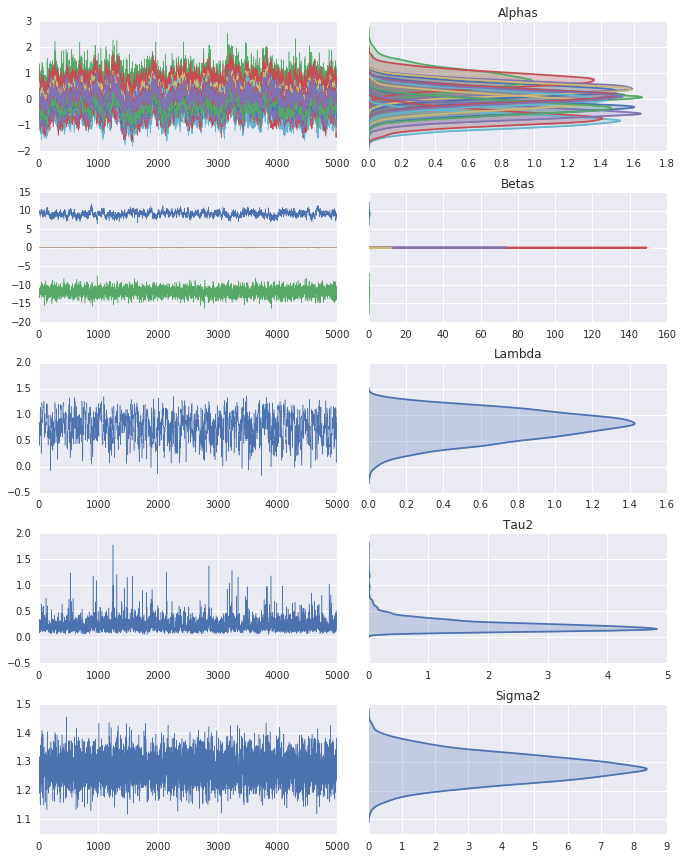

In [7]:
fig, ax = vcsma.trace.plot()
plt.tight_layout()
plt.show()

# `draw` and `sample`

These two functions are used to actually do the sampling. `draw` steps forward once:

In [8]:
vcsma.draw()

And sample steps forward an arbitrary number of times:

In [9]:
vcsma.sample(10)

At this point, we did 5000 initial samples and 11 extra samples. Thus:

In [10]:
vcsma.cycles

5011

# `state`

This is the collection of all of the computed objects during the sampling run. This lets the sampler be very efficient, as computation of any property is only done once during the sample iteration. For example, once $\eta$ has been computed for the lower-level scale component, it can be used elsewhere until there is another update of $\beta$ or $\alpha$. 

All of the following are tracked in the state:

In [11]:
print(vcsma.state.varnames)

['Psi_1', 'PsiTau2i', 'Tau2_an', 'Ij', 'Betas_mean0', 'Tau2_a0', 'PsiTau2', 'Betas_cov0i', 'p', 'PsiLambdai', 'PsiSigma2', 'W', 'Psi_2', 'Rho_max', 'Tau2', 'J', 'DeltatDelta', 'LogRho0', 'XtX', 'Sigma2_b0', 'DeltaAlphas', 'PsiLambda', 'Delta', 'Rho', 'Betas_covm', 'Betas', 'Lambda', 'Lambda_min', 'Rho_min', 'M', 'Sigma2', 'Tau2_b0', 'Sigma2_a0', 'LogLambda0', 'X', 'PsiRhoi', 'XBetas', 'y', 'In', 'Lambda_max', 'PsiSigma2i', 'PsiRho', 'Betas_cov0', 'Alphas', 'N', 'Sigma2_an']


Under the hood, the sampling loop looks like this:

```python

sample(model):
    st = model.state
    
    st.residuals = st.Y - st.X.dot(st.Betas) - st.Delta.dot(st.Alphas)
    ...
```

So, all references inside the sampling loop are about variables in `state` if they're going to be tracked. This is how we achieve the most efficient sampling possible; compute once and store. 

# `configs`
this is where configuration options for the metropolis steps are stored. Each metropolis step has its own entry in `configs`, which stores a few recognized options. You can access these options directly through the initial call.

In [12]:
vcsma.configs

{Rho:{adapt:True, ar_hi:0.6, adapt_step:1.01, accepted:0, proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7fe669c64630>, jump:0.5, ar_low:0.4, max_adapt:500, rejected:0}, Lambda:{adapt:False, ar_hi:0.6, adapt_step:1.01, accepted:2566, proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7fe669c64630>, jump:0.36005153726295713, ar_low:0.4, max_adapt:500, ar:0.4870259481037924, rejected:2445}}

Thus, we can se the previous run's acceptance rate:

In [13]:
vcsma.configs.Lambda.ar

0.4870259481037924

If you're doing heavy customization, it makes the most sense to first initialize the class without sampling. To do this, pass `n_samples=0`. 

In [14]:
vcsese = hlm.both.SESE(Y, X, W=W1, M=W2, Z=Z, membership=membership, 
                      n_samples=0, tuning=500, rho_jump=.22)

/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


This sets up the sampler with a default uninformative configuration. This means the prior precisions are all `I * .001*`, prior means are all 0, spatial parameters are set to `-1/(n-1)`, and prior scale factors are set arbitrarily. 

Options are set by assgning to the property. You can see the contents of the configuration object a few ways:

In [15]:
vcsese.configs.varnames

['Rho', 'Lambda']

In [16]:
vcsese.configs

{Rho:{adapt:True, ar_hi:0.6, adapt_step:1.01, accepted:0, proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7fe669c64630>, jump:0.22, ar_low:0.4, max_adapt:500, rejected:0}, Lambda:{adapt:True, ar_hi:0.6, adapt_step:1.01, accepted:0, proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7fe669c64630>, jump:0.5, ar_low:0.4, max_adapt:500, rejected:0}}

So, we could turn off adaptation in the upper-level parameter and change the jump size by assigning to it:

In [17]:
vcsese.configs.Lambda.adapt = False
vcsese.configs.Lambda.jump  = .25

In [18]:
vcsese.configs

{Rho:{adapt:True, ar_hi:0.6, adapt_step:1.01, accepted:0, proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7fe669c64630>, jump:0.22, ar_low:0.4, max_adapt:500, rejected:0}, Lambda:{adapt:False, ar_hi:0.6, adapt_step:1.01, accepted:0, proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7fe669c64630>, jump:0.25, ar_low:0.4, max_adapt:500, rejected:0}}

In addition, you can adjust prior hyperparameters by assigning to their values in state or passing them in as an argument above:

In [19]:
DeltaZ = vcsese.state.Delta.dot(Z)

So, as is done sometimes in other literature, it may be good to assign the prior mean of $\beta$ to be the OLS estimate:

In [20]:
vcsese.state.Betas_mean0 = ps.spreg.OLS(Y, np.hstack((X, DeltaZ))).betas

And, you can adjust starting values in a similar way:

In [21]:
vcsese.state.Lambda = -.25

Or change the prior on the spatial parameters to be more informative:

In [22]:
from scipy import stats

In [23]:
def Lambda_prior(val):
    if (val < 0) or (val > 1):
        return 0
    return np.log(stats.beta.pdf(val, 2,1))

In [24]:
def Rho_prior(val):
    if (val > .5) or (val < -.5):
        return 0
    return np.log(stats.truncnorm.pdf(val, -.5, .5, loc=0, scale=.5))

In [25]:
vcsese.state.LogLambda0 = Lambda_prior
vcsese.state.LogRho0 = Rho_prior

Sampling the lower-level stuff takes longer than the upper-level stuff.

In [26]:
%time vcsese.draw()

CPU times: user 7.57 s, sys: 244 ms, total: 7.82 s
Wall time: 2.39 s


And, just to show, I've implemented a method that lets you cancel/interrupt sampling and the trace is saved. So, if something's taking longer than you expected, or if the sampler encounters a linear algebra error, the trace is recovered and the exception (if any) is logged.

So, the following should take under 400 seconds. So, 1000 draws would be ~1 hour on my laptop. On the GeoDaBoxx, it's faster, since I've gotten the optimized parallel numerical libraries installed. 

In [27]:
%time vcsese.sample(100)

CPU times: user 8min 12s, sys: 12.8 s, total: 8min 25s
Wall time: 2min 57s


/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/abstracts.py:38: UserWarning: Sampling interrupted, drew 62 samples
  Warn('Sampling interrupted, drew {} samples'.format(self.cycles))


### Performance

To see what takes the longest amount of time, we can check the actual `_sample` function, which is where the evaluation loop of the gibbs step occurs. 

In [36]:
%load_ext line_profiler

In [37]:
%lprun -f vcsese._sample vcsese.draw()

# Remaining Questions/Concerns 

The critical benefit is that this model framework enables significant amounts of novel work on Bayesian MLMs, approximation methods, and novel sampling methods that can be used to estimate these models, such as Hybrid Monte Carlo methods or Automatic Differention Variational Inference. In sum, it opens up the possibility of a few methodological works that I'm trying to knock down in the following order:


### Can NUTS/HMC provide superior samples for models with spatial effects?

This is what I've submitted for NARSC. It is a study of sampling performance and quality over example datasets using hamiltonian samplers and metropolis samplers, and the gridded Gibbs implemented in the HSAR R package for single-level SAR models. I have tested the first two comparisons [here](http://nbviewer.jupyter.org/gist/ljwolf/1e4971754f1e979b7d77e5389487032e), and have built the required Monte Carlo experiment code to test paramaeter recovery. I have already outlined the NARSC draft paper, and aim to have a draft within two to four weeks. That outline will:

1. Discuss more in depth the Hamiltonian/Hybrid Monte Carlo technique mentioned briefly in the bayesian section of the review paper
2. Define how, exactly, it can stand to benefit sampling for spatial econometric models
3. Display results for a simulated example and real-world example.
4. Analyze sampler efficiency (in terms of effective samples per unit time) and in terms of overall autocorrelation and convergence properties. 

### Does an MLM with spatially-correlated pooled intercepts differ significantly from the standard H-MLM estimated on the US Counties NIH data?

This is relatively straightforward now that I understand how to do custom model statement. Due to time constraints and an open [computational bug](https://github.com/pymc-devs/pymc3/issues/555), my going had been slow. But, I believe I have figured a way around the computational bug by using an alternative sampler specification. To complete this, I need to: 

1. Clean and package the data from Lee into a "pressed" format that can be used for rapid fitting of models. That is, no more join, then figure out which counties are missing, then subset the **W**, etc. 
2. Fit standard model with upper-level covariates
3. Fit a standard model with upper-level covariates and lower-level spatial dependence
4. Fit the MLM with a partially pooled upper-level intercept
5. Fit the HLM with a paritally pooled upper-level *correlated* intercept.


### How do the results of Anselin & Arribas-Bel (2013) generalize to HLMs?

Briefly, Anselin & Arribas-Bel (2013) demonstrate that spatial fixed effects (SFE) do not effectively capture observation-level spatial dependence. Indeed, spatial fixed effects are only effective at capturing dependence if dependence is blockwise in structure. Properly speaking, Spatial Fixed effects are a model with independent, unpooled random intercepts in the sense of Gelman et al (2014). If one thinks of positive spatial dependence at the observation-level as a type of smoothing process that removes the independence of the underlying regression, it seems reasonable to investigate whether pooled intercept models are more robust to misspecification in this manner than SFE models. I have already done some preliminary work on the following specifications:

*Spatial Multilevel no pooling*
$$ Y =  \alpha + Z\gamma + X\beta + \epsilon $$
*Spatially-varying pooled intercept*
$$ Y = \Delta\alpha_J + X\beta + \epsilon $$

$$ \alpha_J = a_0 + Z_J\gamma_J + \zeta $$

These can be tested for performance under misspecification against the following dgps:

*Endogenous Lag*
$$ Y = \rho W_1 Y + \alpha + Z\gamma + X\beta + \epsilon $$

*Endogenous Groupwise Lag*
$$ Y = \rho W_2Y^* + \alpha + Z\gamma + X\beta + \epsilon$$

*Endogenously lagged spatially-varying pooled intercept*
$$ Y = \Delta\alpha + X\beta + \epsilon $$

$$ \alpha = \rho W_3\alpha + Z\gamma + a_0 + \zeta $$

Where $\zeta, \epsilon$ are standard normal error terms, $W_1$ is an individual-level proximity spatial weights matrix, $W_2$ is an individual-level groupwise spatial weights matrix, $W_3$ is a group-level proximity spatial weights matrix, and $\Delta$ is the dummy matrix aggregating observations into groups.




### Can approximate gradient techniques be employed to sample models with spatial effects efficiently?

Hamiltonian monte carlo already approximates the continuous gradient using a "leapfrogging" method outlined in Neal (2011) (will be discussed in the NARSC draft. In addition, since the gradient information is only used to make provide an automatic eficient rescaling of proposals, is it possible to use the well-known power series identity:

$$ (I - \rho)^{-1} = (I + \rho W + \rho^2 W^2 + \ldots) $$

to get the gains of efficient automatic proposal scaling (like that implemented in Hoffman & Gelman (2014)'s No U-Turn Sampler) without computing the matrix inverse? Indeed, combining this with fast LU-based sparse determinant computation may enable large spatial econometric models (with multilevel/hierarchical effects) to be sampled efficiently. 